<h2>Linear Regression Analysis of Murder Rate by US State</h2>

<h4>Input Variables</h4>

<ul>
<li>population density</li>
<li>household income</li>
<li>poverty rate</li>
<li>education</li>
<li>suicide rate</li>
<li>incarceration rate</li>
</ul>

<h4>Output Variable</h4>
<ul>
<li>murder rate</li>
</ul>

<a href="http://en.wikipedia.org/wiki/Gun_violence_in_the_United_States_by_state">Gun Violence in the US by State</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_income">List of US States by Income</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment">List of US States by Educational Attainment</a>

<a href="http://usatoday30.usatoday.com/news/health/2007-11-28-depression-suicide-numbers_N.htm">Depression Suicide Numbers</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_incarceration_rate">List of US States by Incarceration</a>

<a href="https://www.census.gov/statab/ranks/rank21.html">Violent Crimes per US State</a>

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_poverty_rate">List of US States by Poverty Rate</a>

In [89]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.linear_model import Lasso

In [48]:
def load_data():
    guns = pd.read_csv("data/guns.csv")
    guns = guns[guns.state != 'District of Columbia']
    
    income = pd.read_csv('data/household_income_2010.txt')
    combined = guns.merge(income[['state', 'income']], on='state')
    
    education = pd.read_csv('data/education.csv')
    combined = combined.merge(education[['state', 'high_school', 'bachelors', 'advanced']], on='state')
    combined['no_high_school'] = 100. - combined['high_school']
    
    suicide = pd.read_csv('data/suicide.csv')
    combined = combined.merge(suicide[['state', 'suicide_rate']], on='state')
    
    incarceration = pd.read_csv('data/incarceration.csv')
    combined = combined.merge(incarceration[['state','incarceration_rate']], on='state')
    
    violence = pd.read_csv('data/violence.csv')
    combined = combined.merge(violence[['state','violent_crime_rate']], on='state')
    
    poverty = pd.read_csv('data/poverty.csv')
    combined = combined.merge(poverty[['state','poverty_rate']], on='state')
    
    return combined

combined = load_data()

In [49]:
primary_cols = ['murder_rate', 'population_density', 'high_school', 'suicide_rate', 'incarceration_rate', 'poverty_rate', 
                'income', 'gun_ownership']

In [50]:
print combined.columns
combined[primary_cols].corr()

Index([u'state', u'population', u'population_density', u'murders', u'gun_murders', u'gun_ownership', u'murder_rate', u'gun_murder_rate', u'income', u'high_school', u'bachelors', u'advanced', u'no_high_school', u'suicide_rate', u'incarceration_rate', u'violent_crime_rate', u'poverty_rate'], dtype='object')


,murder_rate,population_density,high_school,suicide_rate,incarceration_rate,poverty_rate,income,gun_ownership
murder_rate,1.000000,0.139420,-0.669136,-0.081453,0.655537,0.515520,-0.190506,-0.119836
population_density,0.139420,1.000000,-0.046725,-0.641630,-0.270220,-0.289172,0.496774,-0.739535
high_school,-0.669136,-0.046725,1.000000,0.115563,-0.626972,-0.766861,0.446929,0.015967
suicide_rate,-0.081453,-0.641630,0.115563,1.000000,0.203124,0.157947,-0.293510,0.662998
incarceration_rate,0.655537,-0.270220,-0.626972,0.203124,1.000000,0.657218,-0.530396,0.341129
poverty_rate,0.515520,-0.289172,-0.766861,0.157947,0.657218,1.000000,-0.704510,0.349344
income,-0.190506,0.496774,0.446929,-0.293510,-0.530396,-0.704510,1.000000,-0.560928
gun_ownership,-0.119836,-0.739535,0.015967,0.662998,0.341129,0.349344,-0.560928,1.000000


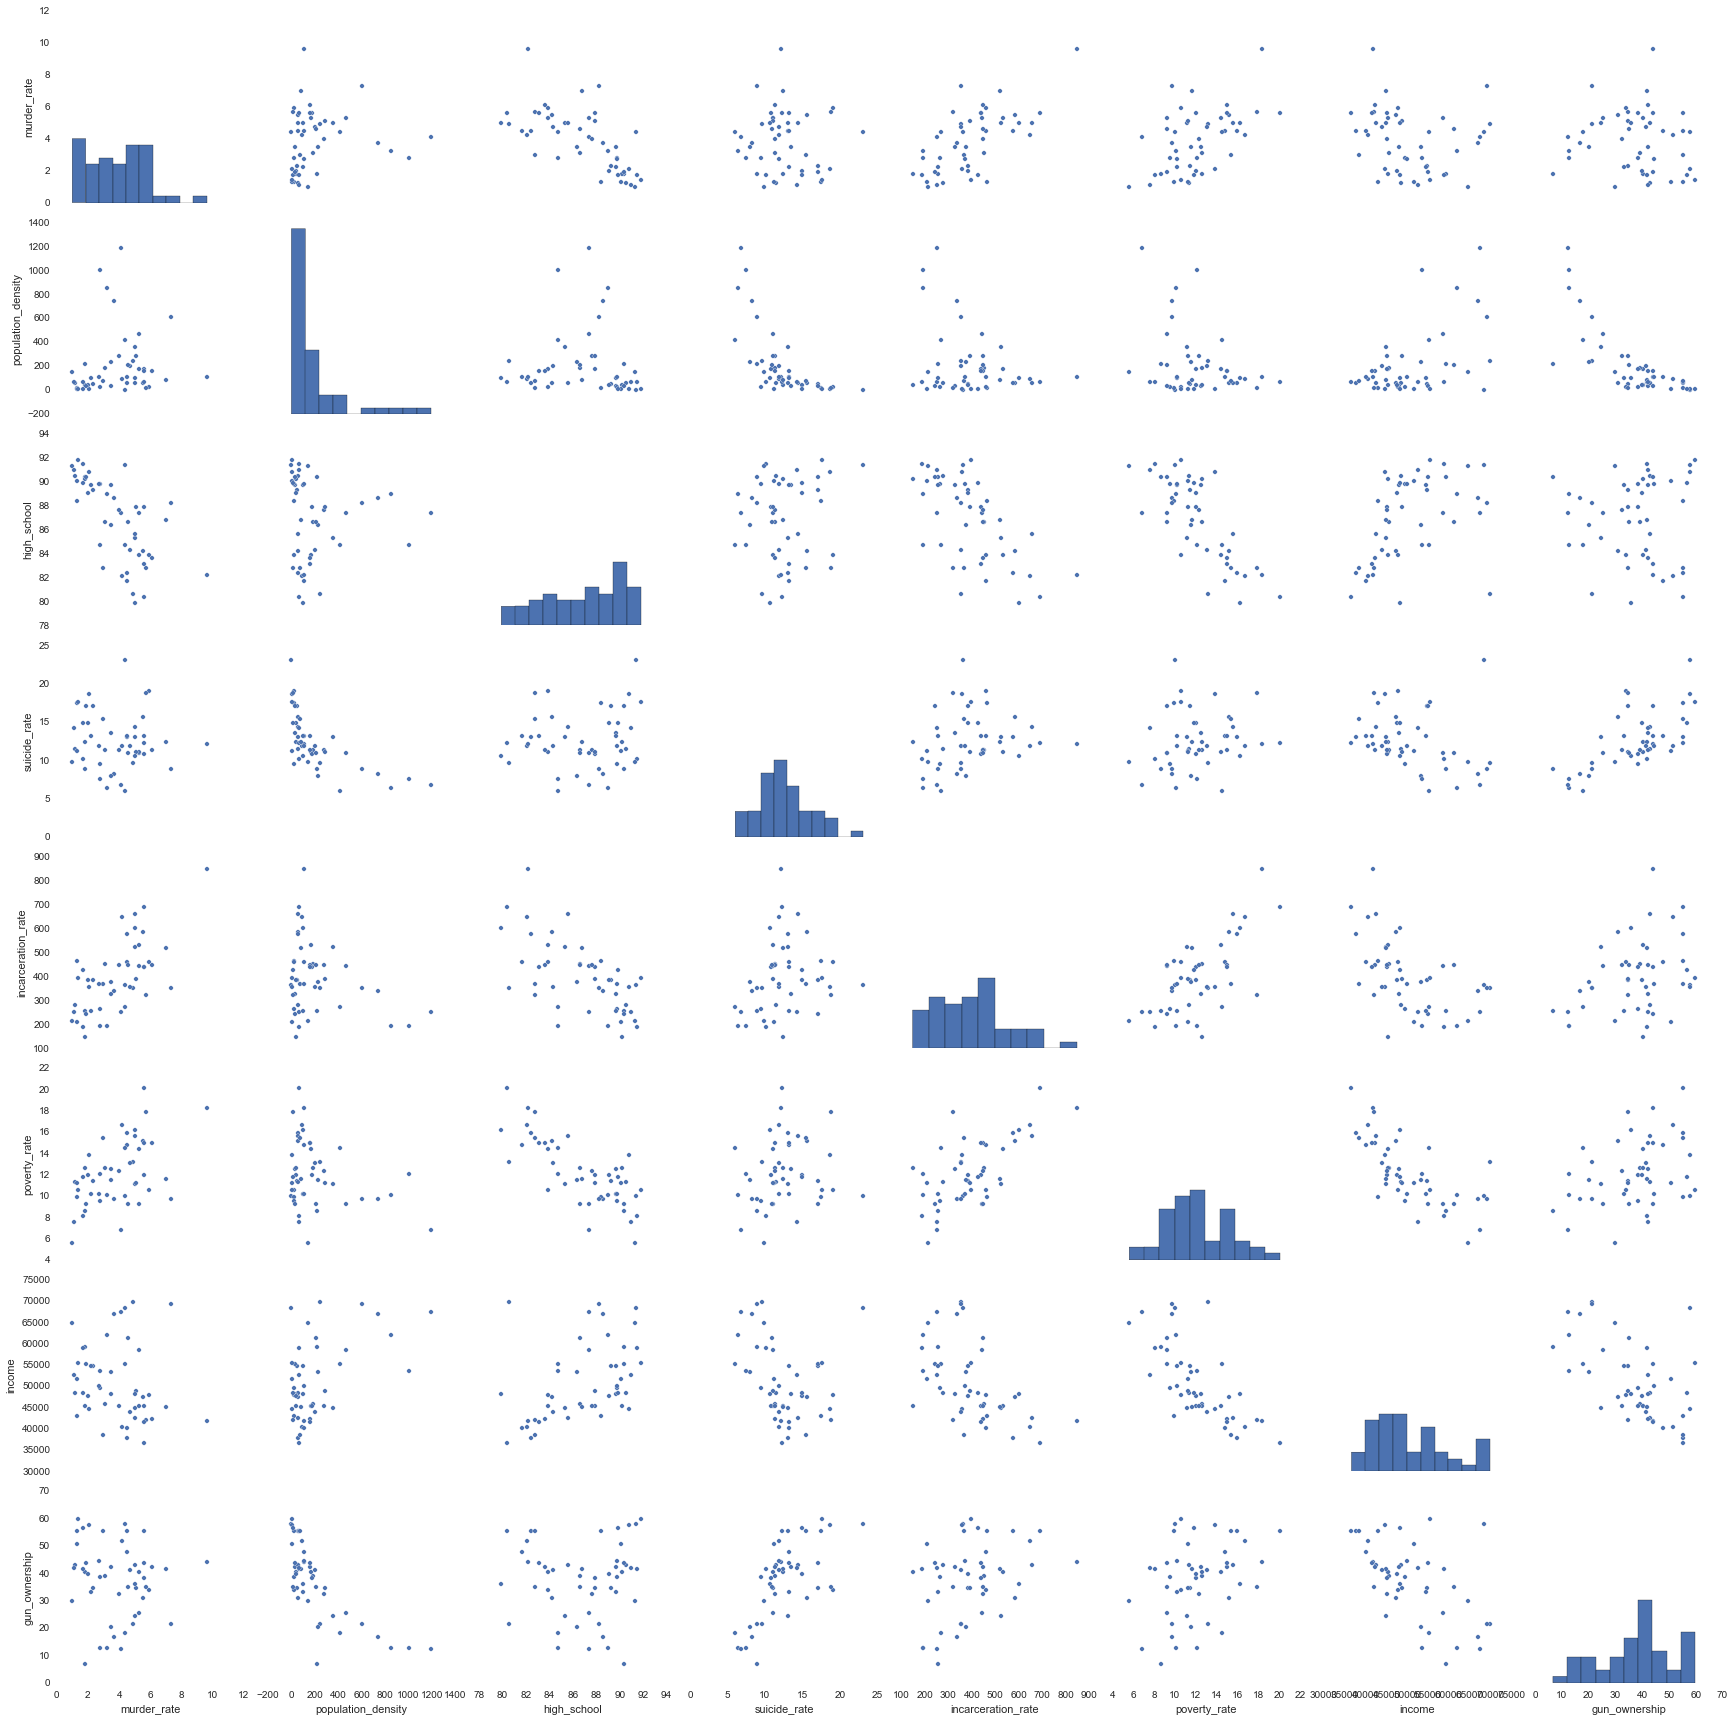

In [65]:
sns.pairplot(combined[primary_cols])
plt.savefig('corr.png')

In [74]:
# linear fit to line
def fit_lin(df, title, x_col_name, y_col_name="murder_rate"):
    
    # Get column data for plot
    x = df[x_col_name].values.reshape(-1,1)
    y = df[y_col_name].values
            
    # Create linear regression model and perform fit
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    print "residuals", regr.residues_
    print "Coefficients: \n", regr.coef_

    # The mean square error
    print("Residual sum of squares: %.2f" % np.mean((regr.predict(x) - y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
    print "intercept", regr.intercept_

    plt.axes().grid(b=False)
    plt.axes(axisbg='white')    
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    
    plt.scatter(x, y, color='blue', alpha=0.2, s=df['population']/25000.)
    plt.plot(x, regr.predict(x), color='red', linewidth=1, alpha=1.0)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
        
    plt.suptitle(title, fontsize=20)
    plt.xlabel(x_col_name.replace('_', ' '), fontsize=12)
    plt.ylabel(y_col_name.replace('_', ' '), fontsize=12)

In [75]:
# linear fit to polynomial
def fit_poly(df, title, x_col_name, y_col_name="murder_rate", degree=4):

    x = df[x_col_name].values.reshape(-1,1)
    y = df[y_col_name].values.reshape(-1,1)
    
    degree = 4
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(x, y)
        
    x_min = df[x_col_name].min()
    x_max = df[x_col_name].max() 
    x_plot = np.linspace(x_min, x_max, 100)
    
    fig,ax = plt.subplots(1,1)
    ax.scatter(x, y, s=df['population']/25000, alpha=0.25)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red')
    
    plt.suptitle(title, fontsize=20)
    plt.xlabel(x_col_name.replace('_', ' '), fontsize=12)
    plt.ylabel(x_col_name.replace('_', ' '), fontsize=12)
    
    plt.show()

In [76]:
# OLS fit
def fit_ols(df, x_col_name, y_col_name="murder_rate"):
    ols_fit = smf.ols(y_col_name + ' ~ ' + x_col_name, data=df).fit()
    print ols_fit.pvalues
    print ols_fit.summary()

In [92]:
def fit_lasso(df, title, x_col_name, y_col_name="murder_rate", degree=4, alpha=1e-3):
    
    x = df[x_col_name].values.reshape(-1,1)
    y = df[y_col_name].values.reshape(-1,1)
    
    degree = 4
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=1000))
    est.fit(x, y)
        
    x_min = df[x_col_name].min()
    x_max = df[x_col_name].max() 
    x_plot = np.linspace(x_min, x_max, 100)
    
    fig,ax = plt.subplots(1,1)
    ax.scatter(x, y, s=df['population']/25000, alpha=0.25)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red')
    
    plt.suptitle(title, fontsize=20)
    plt.xlabel(x_col_name.replace('_', ' '), fontsize=12)
    plt.ylabel(x_col_name.replace('_', ' '), fontsize=12)
    
    plt.show()

Intercept             1.428458e-14
population_density    3.342258e-01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9515
Date:                Sun, 21 Jun 2015   Prob (F-statistic):              0.334
Time:                        22:35:07   Log-Likelihood:                -101.57
No. Observations:                  50   AIC:                             207.1
Df Residuals:                      48   BIC:                             211.0
Df Model:                           1                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.6427 

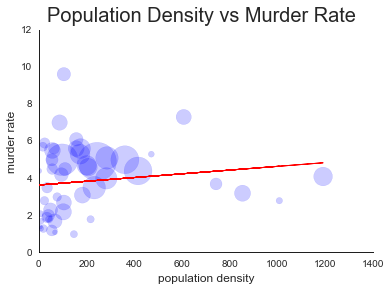

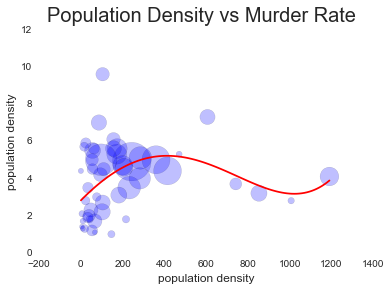

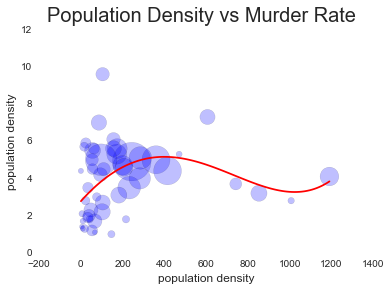

In [93]:
fit_ols(combined, 'population_density')
fit_lin(combined, 'Population Density vs Murder Rate', 'population_density')
fit_poly(combined, 'Population Density vs Murder Rate', 'population_density')
fit_lasso(combined, 'Population Density vs Murder Rate', 'population_density')

residuals 167.241799286
Coefficients: 
[ -4.05336363e-05]
Residual sum of squares: 3.34
Variance score: 0.04
intercept 5.89076852181


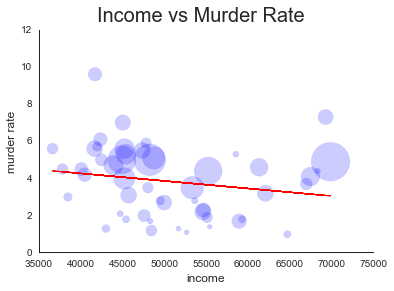

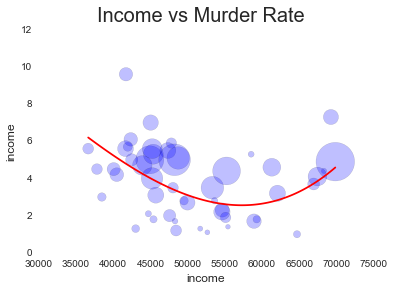

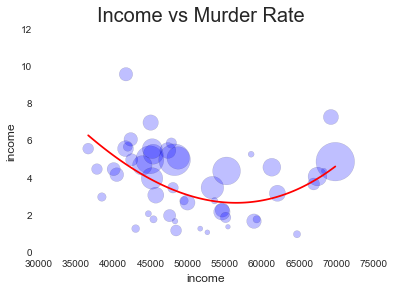

In [94]:
fit_lin(combined, 'Income vs Murder Rate', 'income')
plt.xlim((35000, 75000))
plt.axvline(35000, color='black')
fit_poly(combined, 'Income vs Murder Rate', 'income')
fit_lasso(combined, 'Income vs Murder Rate', 'income')

residuals 127.419807051
Coefficients: 
[ 0.31876058]
Residual sum of squares: 2.55
Variance score: 0.27
intercept -0.0303909347793


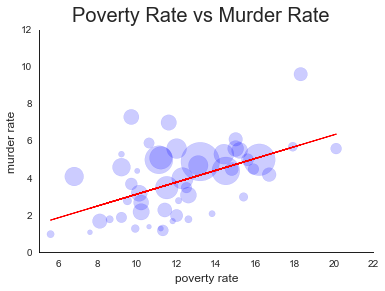

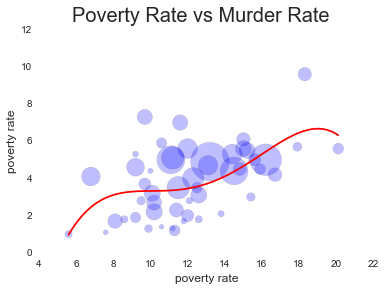

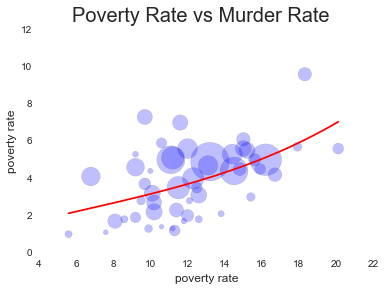

In [95]:
fit_lin(combined, 'Poverty Rate vs Murder Rate', 'poverty_rate')
plt.xlim((5, 22))
plt.axvline(5, color='black')
fit_poly(combined, 'Poverty Rate vs Murder Rate', 'poverty_rate')
fit_lasso(combined, 'Poverty Rate vs Murder Rate', 'poverty_rate')

residuals 95.8387727487
Coefficients: 
[-0.36907788]
Residual sum of squares: 1.92
Variance score: 0.45
intercept 35.9032714709


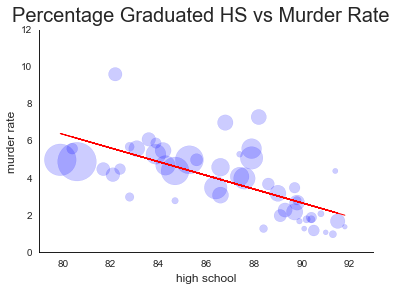

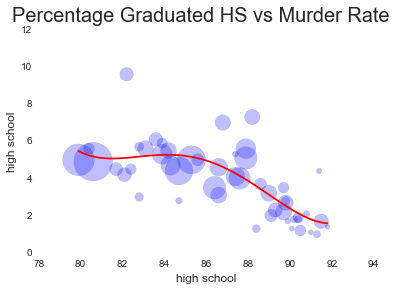

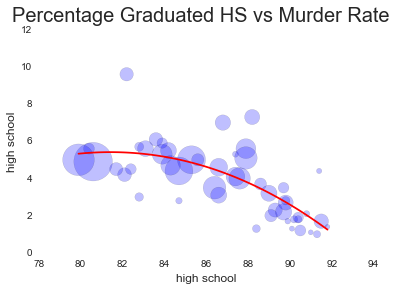

In [96]:
fit_lin(combined, 'Percentage Graduated HS vs Murder Rate', 'high_school')
plt.xlim((79,93))
plt.axvline(79, color='black')
fit_poly(combined, 'Percentage Graduated HS vs Murder Rate', 'high_school')
fit_lasso(combined, 'Percentage Graduated HS vs Murder Rate', 'high_school')

residuals 98.964934182
Coefficients: 
[ 0.00844509]
Residual sum of squares: 1.98
Variance score: 0.43
intercept 0.49945917086


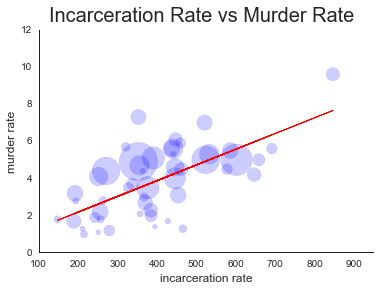

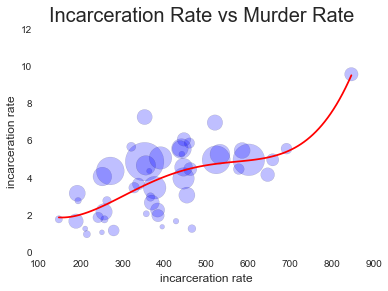

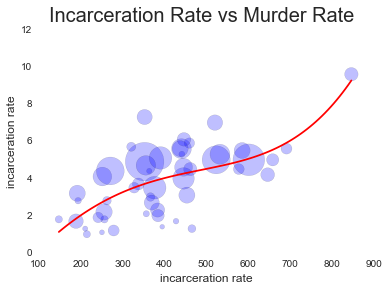

In [97]:
fit_lin(combined, 'Incarceration Rate vs Murder Rate', 'incarceration_rate')
plt.xlim((100,950))
plt.axvline(100, color='black')
plt.savefig('incarceration.png')
fit_poly(combined, 'Incarceration Rate vs Murder Rate', 'incarceration_rate')
fit_lasso(combined, 'Incarceration Rate vs Murder Rate', 'incarceration_rate')

residuals 172.388645354
Coefficients: 
[-0.04306383]
Residual sum of squares: 3.45
Variance score: 0.01
intercept 4.37735051119


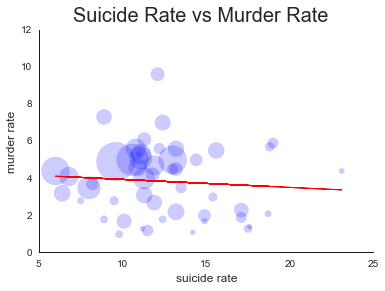

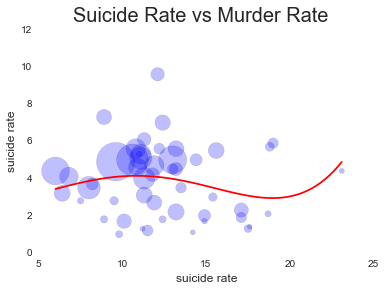

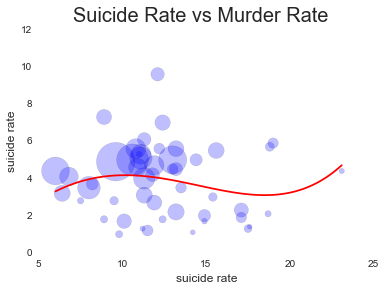

In [98]:
fit_lin(combined, 'Suicide Rate vs Murder Rate', 'suicide_rate')
plt.xlim((5,25))
plt.axvline(5, color='black')
fit_poly(combined, 'Suicide Rate vs Murder Rate', 'suicide_rate')
fit_lasso(combined, 'Suicide Rate vs Murder Rate', 'suicide_rate')

residuals 171.04784627
Coefficients: 
[-0.01687491]
Residual sum of squares: 3.42
Variance score: 0.01
intercept 4.47469899309


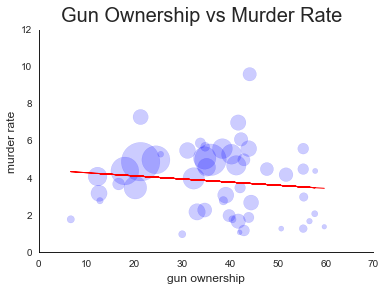

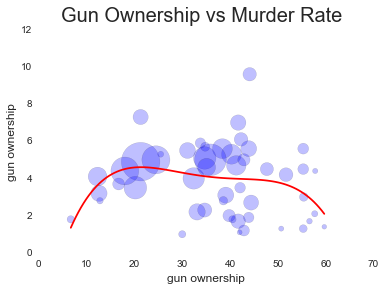

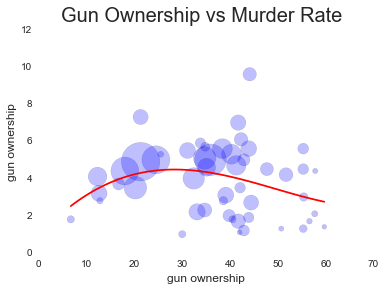

In [99]:
fit_lin(combined, 'Gun Ownership vs Murder Rate', 'gun_ownership')
fit_poly(combined, 'Gun Ownership vs Murder Rate', 'gun_ownership')
fit_lasso(combined, 'Gun Ownership vs Murder Rate', 'gun_ownership')

residuals 95.8387727487
Coefficients: 
[ 0.36907788]
Residual sum of squares: 1.92
Variance score: 0.45
intercept -1.00451621115


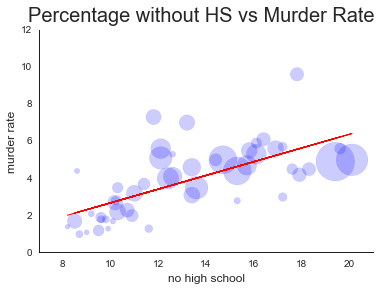

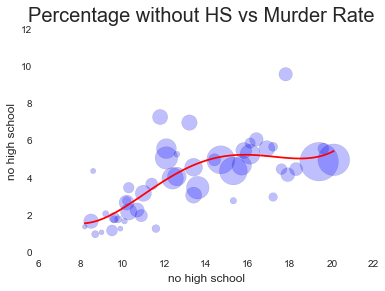

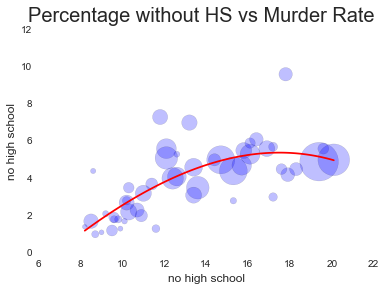

In [100]:
fit_lin(combined, 'Percentage without HS vs Murder Rate', 'no_high_school')
plt.xlim((7,21))
plt.axvline(7, color='black')

fit_poly(combined, 'Percentage without HS vs Murder Rate', 'no_high_school')
fit_lasso(combined, 'Percentage without HS vs Murder Rate', 'no_high_school')

residuals 60.5646129456
Coefficients: 
[ 0.00825364]
Residual sum of squares: 1.21
Variance score: 0.65
intercept 0.455345572578


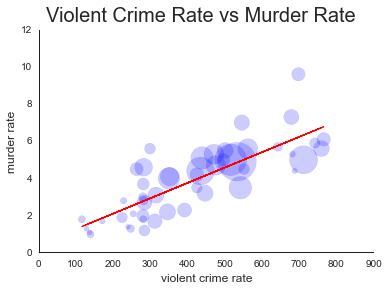

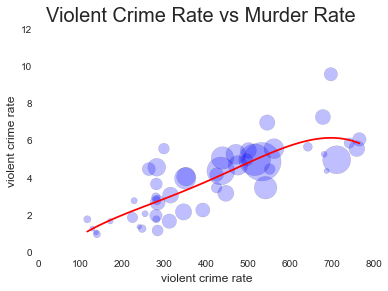

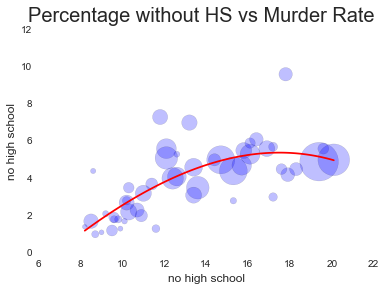

In [101]:
fit_lin(combined, 'Violent Crime Rate vs Murder Rate', 'violent_crime_rate')
fit_poly(combined, 'Violent Crime Rate vs Murder Rate', 'violent_crime_rate')
fit_lasso(combined, 'Violent Crime Rate vs Murder Rate', 'violent_crime_rate')